In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
def get_historical_data(symbol, start_date = None):
    api_key = 'BPUROSV7R6OUF7NS'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

aapl = get_historical_data('AAPL', '2020-01-01')
aapl

,open,high,low,close,adj close,volume
2020-01-02,296.24,300.6000,295.19,300.35,73.356067,33911864.0
2020-01-03,297.15,300.5800,296.50,297.43,72.642900,36633878.0
2020-01-06,293.79,299.9600,292.75,299.80,73.221738,29644644.0
2020-01-07,299.84,300.9000,297.48,298.39,72.877366,27877655.0
2020-01-08,297.16,304.4400,297.16,303.19,74.049696,33090946.0
...,...,...,...,...,...,...
2023-03-20,155.07,157.8200,154.15,157.40,157.400000,73641415.0
2023-03-21,157.32,159.4000,156.54,159.28,159.280000,73938285.0
2023-03-22,159.30,162.1400,157.81,157.83,157.830000,75701811.0
2023-03-23,158.83,161.5501,157.68,158.93,158.930000,67622060.0


In [4]:
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

aapl['plus_di'] = pd.DataFrame(get_adx(aapl['high'], aapl['low'], aapl['close'], 14)[0]).rename(columns = {0:'plus_di'})
aapl['minus_di'] = pd.DataFrame(get_adx(aapl['high'], aapl['low'], aapl['close'], 14)[1]).rename(columns = {0:'minus_di'})
aapl['adx'] = pd.DataFrame(get_adx(aapl['high'], aapl['low'], aapl['close'], 14)[2]).rename(columns = {0:'adx'})
aapl = aapl.dropna()
aapl.tail()

,open,high,low,close,adj close,volume,plus_di,minus_di,adx
2023-03-20,155.07,157.8200,154.15,157.40,157.40,73641415.0,30.619039,16.848983,23.761254
2023-03-21,157.32,159.4000,156.54,159.28,159.28,73938285.0,31.242407,15.505915,24.159842
2023-03-22,159.30,162.1400,157.81,157.83,157.83,75701811.0,33.341639,13.986079,24.875490
2023-03-23,158.83,161.5501,157.68,158.93,158.93,67622060.0,31.755640,13.571969,26.015892
2023-03-24,158.86,160.3400,157.85,160.25,160.25,59256343.0,31.161178,13.317903,27.023050


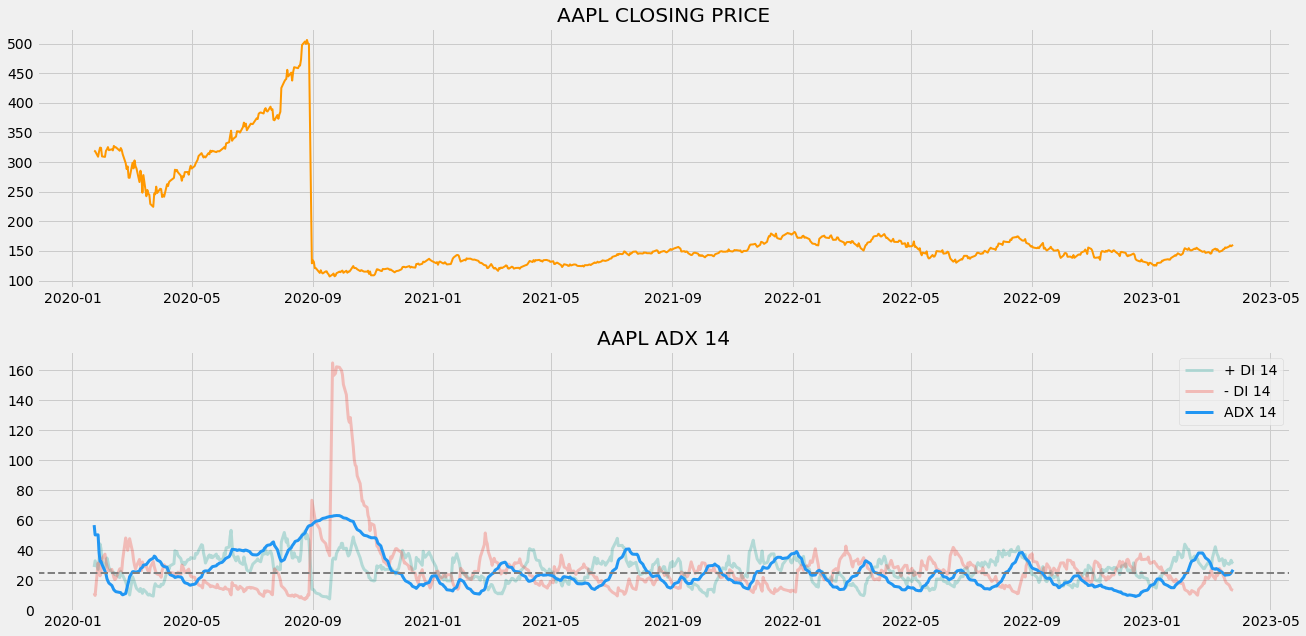

In [5]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(aapl['close'], linewidth = 2, color = '#ff9800')
ax1.set_title('AAPL CLOSING PRICE')
ax2.plot(aapl['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(aapl['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(aapl['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('AAPL ADX 14')
plt.show()

In [6]:
def implement_adx_strategy(prices, pdi, ndi, adx):
    buy_price = []
    sell_price = []
    adx_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if adx[i-1] < 25 and adx[i] > 25 and pdi[i] > ndi[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                adx_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_signal.append(0)
        elif adx[i-1] < 25 and adx[i] > 25 and ndi[i] > pdi[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                adx_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            adx_signal.append(0)
            
    return buy_price, sell_price, adx_signal

buy_price, sell_price, adx_signal = implement_adx_strategy(aapl['close'], aapl['plus_di'], aapl['minus_di'], aapl['adx'])

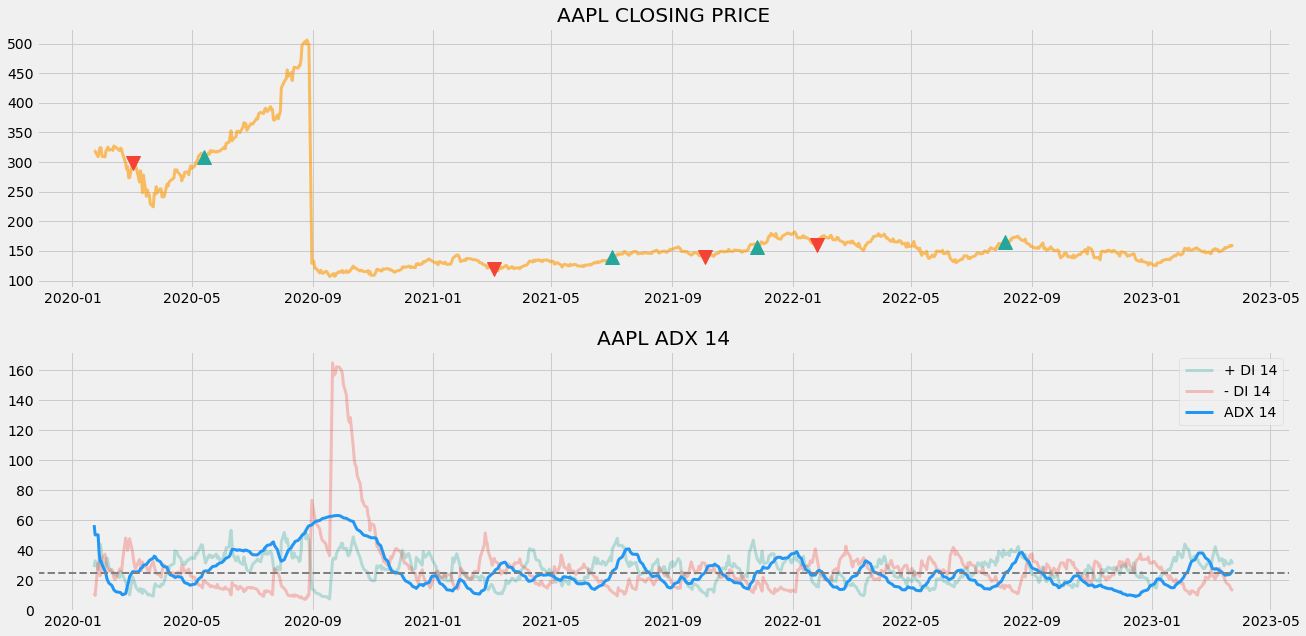

In [7]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(aapl['close'], linewidth = 3, color = '#ff9800', alpha = 0.6)
ax1.set_title('AAPL CLOSING PRICE')
ax1.plot(aapl.index, buy_price, marker = '^', color = '#26a69a', markersize = 14, linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(aapl.index, sell_price, marker = 'v', color = '#f44336', markersize = 14, linewidth = 0, label = 'SELL SIGNAL')
ax2.plot(aapl['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(aapl['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(aapl['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('AAPL ADX 14')
plt.show()

In [8]:
position = []
for i in range(len(adx_signal)):
    if adx_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(aapl['close'])):
    if adx_signal[i] == 1:
        position[i] = 1
    elif adx_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = aapl['close']
plus_di = aapl['plus_di']
minus_di = aapl['minus_di']
adx = aapl['adx']
adx_signal = pd.DataFrame(adx_signal).rename(columns = {0:'adx_signal'}).set_index(aapl.index)
position = pd.DataFrame(position).rename(columns = {0:'adx_position'}).set_index(aapl.index)

frames = [close_price, plus_di, minus_di, adx, adx_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,plus_di,minus_di,adx,adx_signal,adx_position
2020-01-23,319.23,28.862463,11.390983,56.733763,0,1
2020-01-24,318.31,32.981969,9.933521,50.203461,0,1
2020-01-27,308.95,27.234332,31.494957,50.269800,0,1
2020-01-28,317.69,33.758710,26.322991,38.394640,0,1
2020-01-29,324.34,44.214849,22.983880,32.709233,0,1
...,...,...,...,...,...,...
2023-03-20,157.40,30.619039,16.848983,23.761254,0,1
2023-03-21,159.28,31.242407,15.505915,24.159842,0,1
2023-03-22,157.83,33.341639,13.986079,24.875490,0,1
2023-03-23,158.93,31.755640,13.571969,26.015892,0,1


In [9]:
aapl_ret = pd.DataFrame(np.diff(aapl['close'])).rename(columns = {0:'returns'})
adx_strategy_ret = []

for i in range(len(aapl_ret)):
    returns = aapl_ret['returns'][i]*strategy['adx_position'][i]
    adx_strategy_ret.append(returns)
    
adx_strategy_ret_df = pd.DataFrame(adx_strategy_ret).rename(columns = {0:'adx_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/aapl['close'][-1])
adx_investment_ret = []

for i in range(len(adx_strategy_ret_df['adx_returns'])):
    returns = number_of_stocks*adx_strategy_ret_df['adx_returns'][i]
    adx_investment_ret.append(returns)

adx_investment_ret_df = pd.DataFrame(adx_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(adx_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the ADX strategy by investing $100k in AAPL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the ADX strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the ADX strategy by investing $100k in AAPL : -131651.52
Profit percentage of the ADX strategy : -132%


In [10]:
def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('ADX Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

Benchmark profit by investing $100k : 17861.76
Benchmark Profit percentage : 17%
ADX Strategy profit is -149% higher than the Benchmark Profit
